In [1]:
%cd drive/MyDrive/ML_finance/jansen

/content/drive/MyDrive/ML_finance/jansen


# Packages

In [2]:
%matplotlib inline

import pandas_datareader.data as web
import numpy as np

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Time Series Analysis and Stationarity

In [3]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags

    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)

        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        print(q_p)
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'

        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

        print(s)

        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0],auto_ylims=True)
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1],auto_ylims=True)

        axes[1][0].set_xlabel('Lag')

        axes[1][1].set_xlabel('Lag')

        fig.suptitle(title, fontsize=14)

        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [4]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

In [5]:
components = tsa.seasonal_decompose(industrial_production, model='additive')

In [8]:
industrial_production.head()

DATE
1988-01-01    55.6556
1988-02-01    56.8482
1988-03-01    57.5280
1988-04-01    57.7532
1988-05-01    57.8484
Name: IPGMFN, dtype: float64

In [12]:
components.trend.tail()

DATE
2017-08-01   NaN
2017-09-01   NaN
2017-10-01   NaN
2017-11-01   NaN
2017-12-01   NaN
Name: trend, dtype: float64

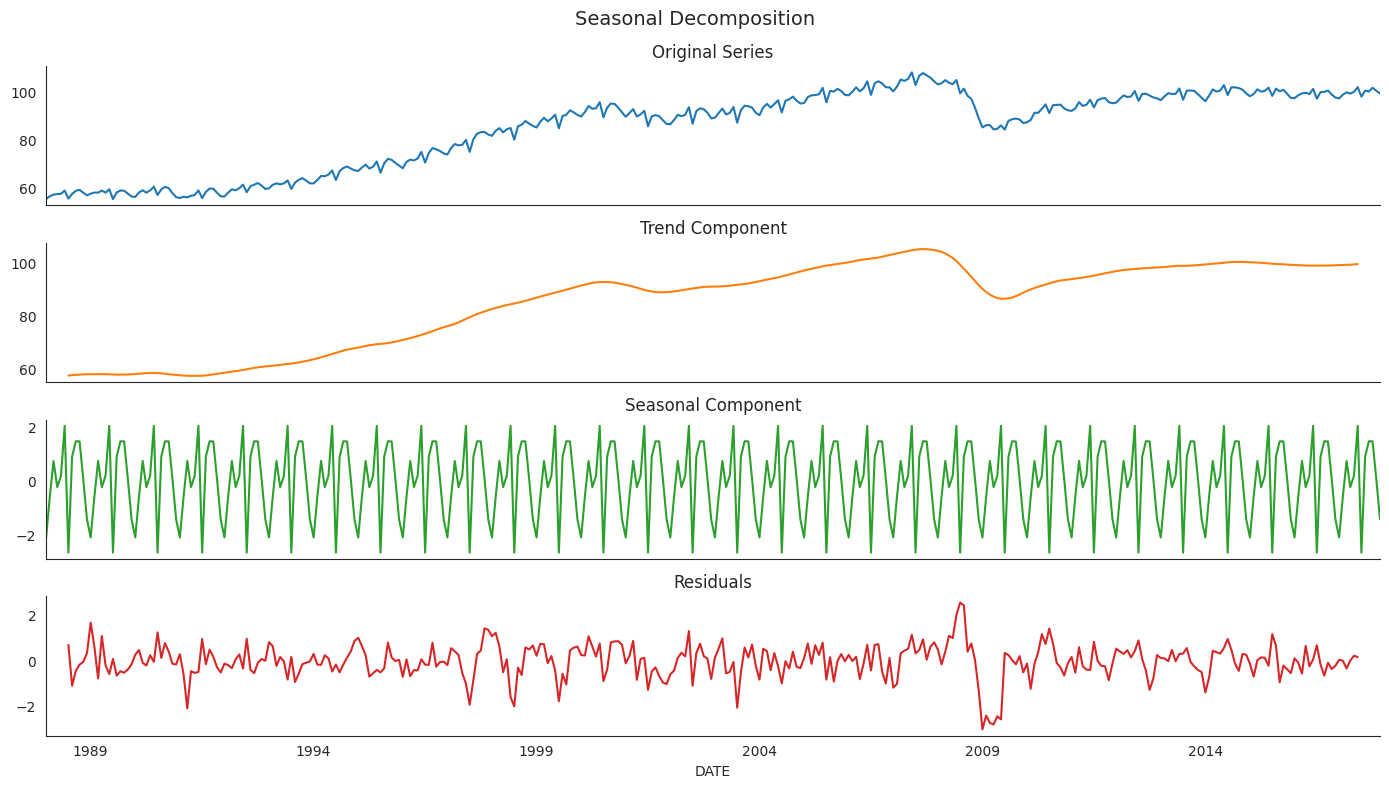

In [13]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8),
            title=['Original Series', 'Trend Component',
                   'Seasonal Component','Residuals'],
            legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [14]:
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

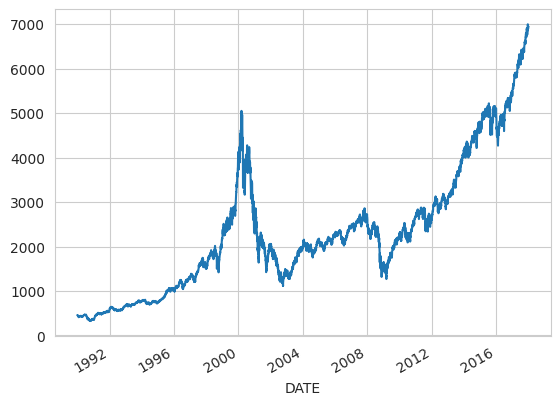

In [17]:
nasdaq.plot();

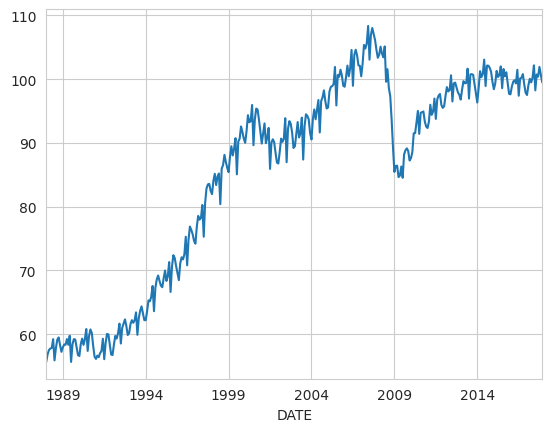

In [18]:
industrial_production.plot();

In [19]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

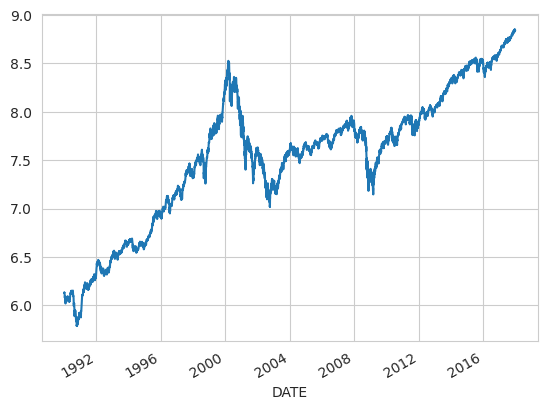

In [20]:
nasdaq_log.plot();

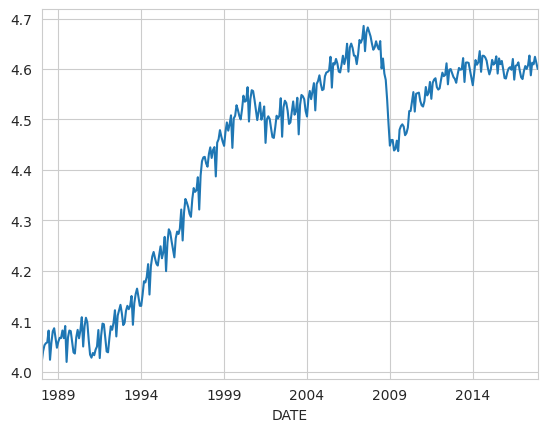

In [21]:
industrial_production_log.plot();

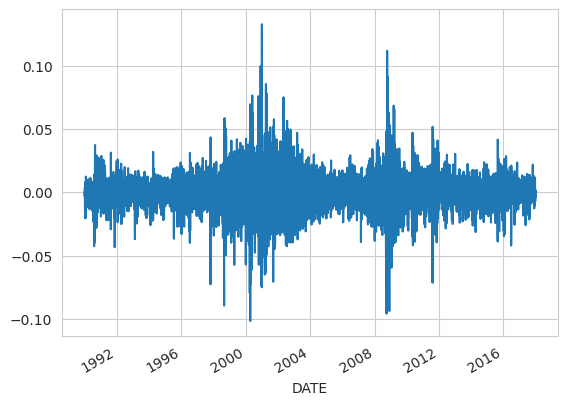

In [22]:
nasdaq_log_diff = nasdaq_log.diff().dropna()
nasdaq_log_diff.plot();

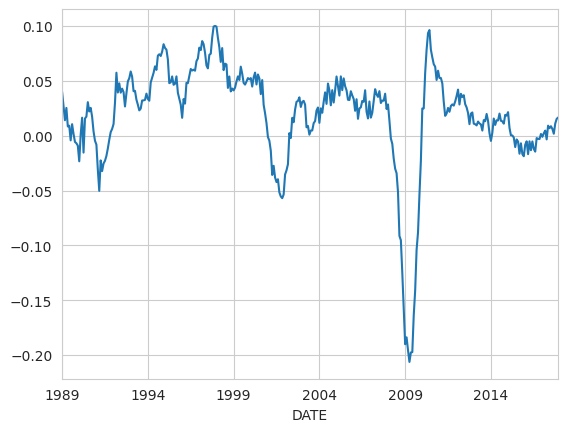

In [23]:
industrial_production_log_diff = industrial_production_log.diff(12).dropna()
industrial_production_log_diff.plot();

In [25]:
tsa.adfuller(nasdaq.dropna())

(0.8771442321587867,
 0.9927846843972561,
 35,
 7020,
 {'1%': -3.4312818650683687,
  '5%': -2.861951809678974,
  '10%': -2.5669892022994945},
 70418.67521000482)

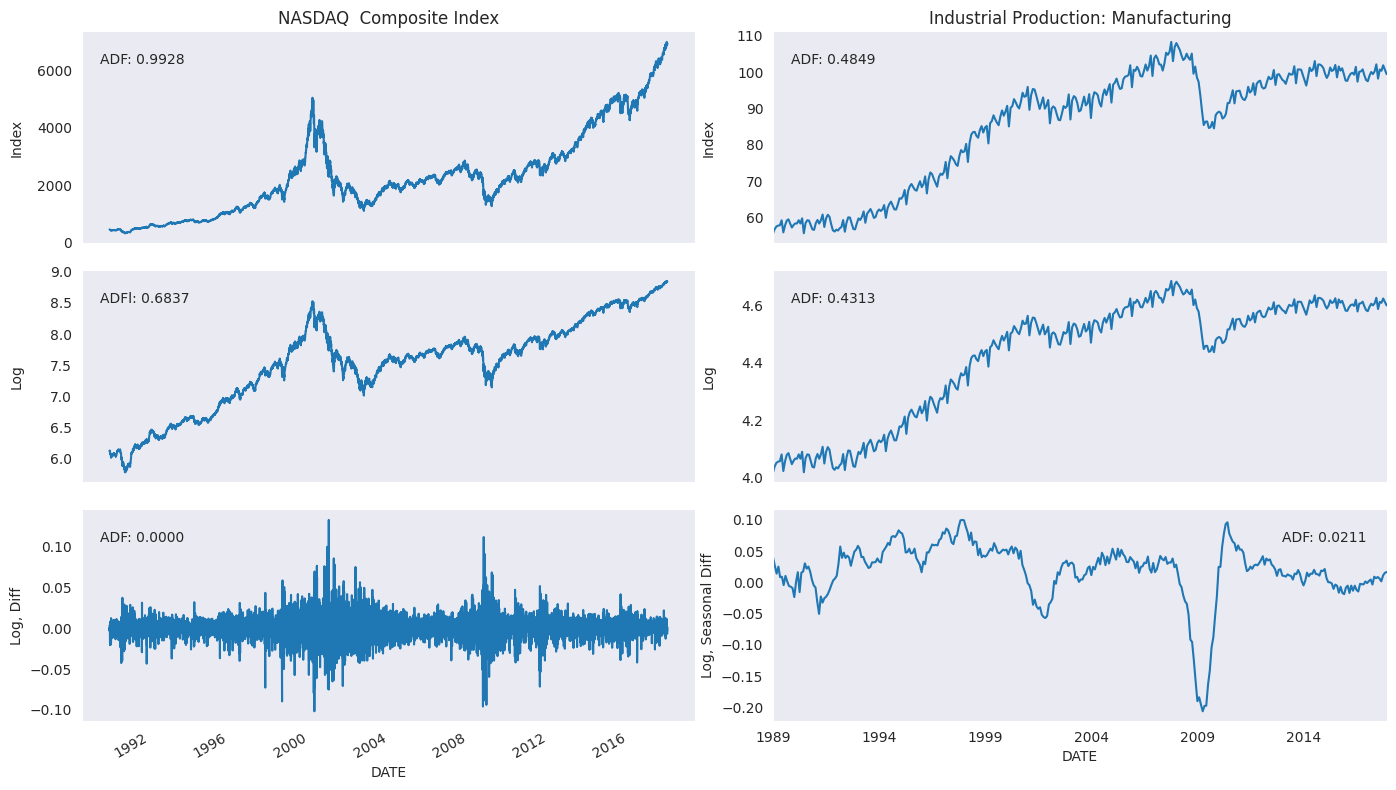

In [33]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    nasdaq.plot(ax=axes[0][0],
                title='NASDAQ  Composite Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_log.plot(ax=axes[1][0],
                    sharex=axes[0][0])
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[2][0],
                         sharex=axes[0][0])
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1],
                                   sharex=axes[0][1])
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1],
                                        sharex=axes[0][1])
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

0.0
Mean:         0.00
SD:             0.01
Skew:        -0.00
Kurtosis:     0.00


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


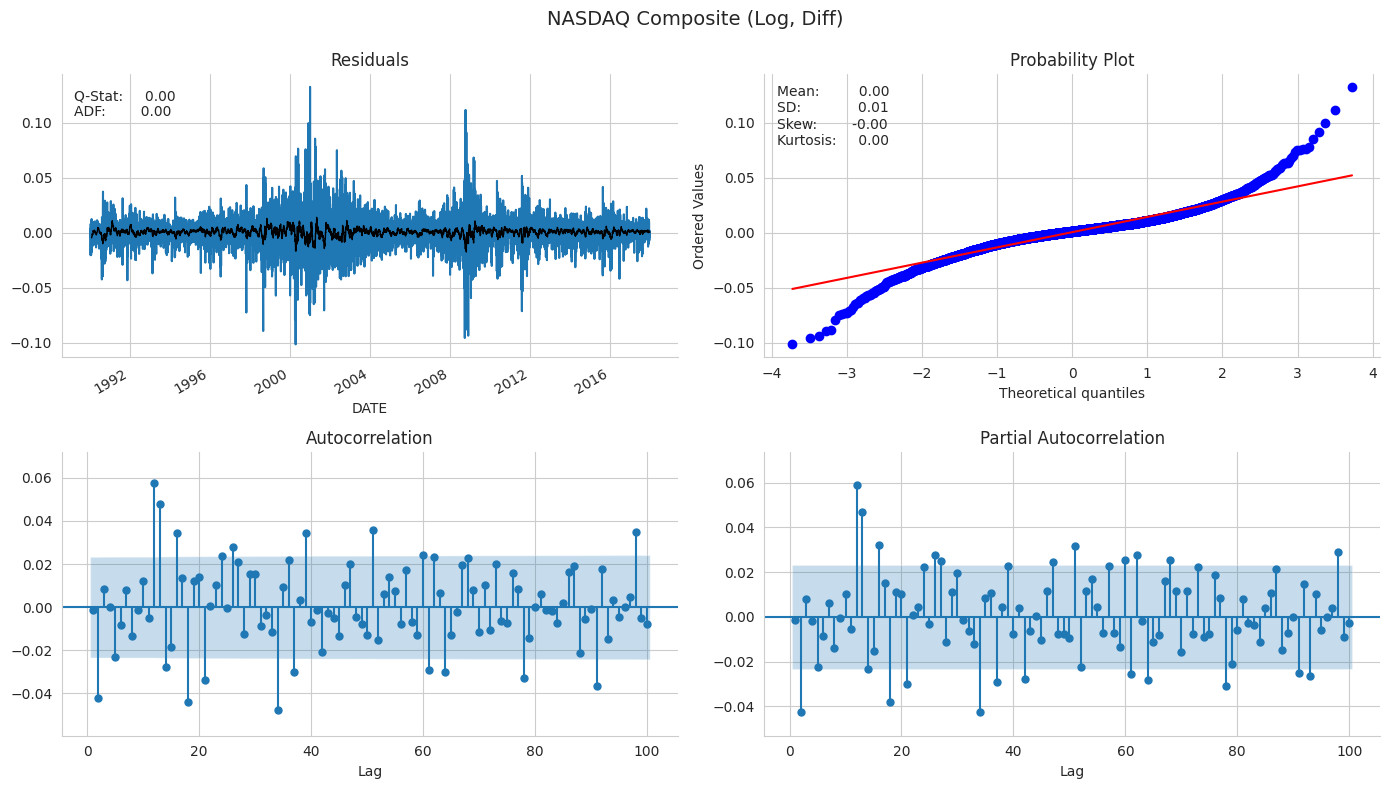

In [34]:
plot_correlogram(nasdaq_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)')

2.5556044883160984e-78
Mean:         0.00
SD:             0.05
Skew:        -0.00
Kurtosis:     0.00


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


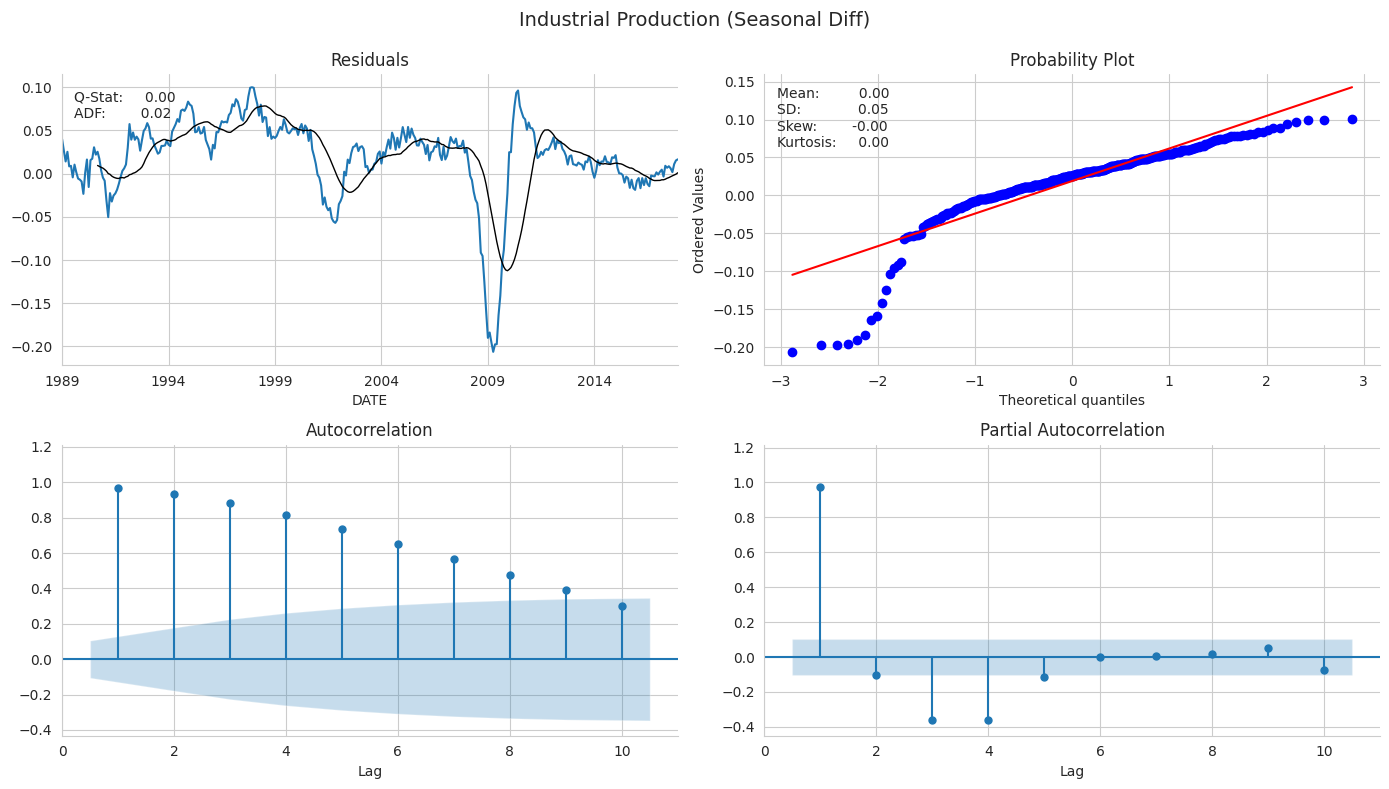

In [35]:
plot_correlogram(industrial_production_log_diff, title='Industrial Production (Seasonal Diff)')

# ARIMA models

In [6]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [8]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

nasdaq_log = np.log(nasdaq)

#nasdaq_log.index=nasdaq_log.index.to_period('d')
nasdaq_log_diff = nasdaq_log.diff().dropna()

industrial_production_log = np.log(industrial_production)

# seasonal differencing => instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

In [9]:
import statsmodels

In [101]:
model1 = sm.tsa.arima.ARIMA(nasdaq_log, order=(2,1,2)).fit()
model2 = sm.tsa.arima.ARIMA(nasdaq_log_diff, order=(2,0,2)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [102]:
print(model1.params.sort_index())
print(model2.params.sort_index())

ar.L1    -0.224551
ar.L2    -0.169854
ma.L1     0.224049
ma.L2     0.128358
sigma2    0.000208
dtype: float64
ar.L1    -0.188582
ar.L2    -0.130675
const     0.000383
ma.L1     0.187295
ma.L2     0.088260
sigma2    0.000208
dtype: float64


In [103]:
model1 = tsa.ARIMA(endog=nasdaq_log_diff, order=(2,0,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

print(model1.params.sort_index())
print(model2.params.sort_index())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ar.L1    -0.188582
ar.L2    -0.130675
const     0.000383
ma.L1     0.187295
ma.L2     0.088260
sigma2    0.000208
dtype: float64
ar.L1    -0.224551
ar.L2    -0.169854
ma.L1     0.224049
ma.L2     0.128358
sigma2    0.000208
dtype: float64


In [ ]:
model1 = tsa.statespace.SARIMAX(industrial_production_log,
                                order=(2,0,2),
                                seasonal_order=(0,1,0,12)).fit()

model2 = tsa.statespace.SARIMAX(industrial_production_log_diff,
                                order=(2,0,2),
                                seasonal_order=(0,0,0,12)).fit()

model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))


In [ ]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p,0, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast = model.forecast(steps=1).values[0]
            y_pred.append(forecast)
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

In [11]:
arima_results = pd.DataFrame(results).T
arima_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arima_results.index.names = ['p', 'q']
arima_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [12]:
arima_results

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.030249 -529.830207 -521.467732          0.0           0.0
  2  0.023441 -594.944948 -583.794981          0.0           0.0
  3  0.018508 -650.790818 -636.853359          0.0           0.0
  4  0.014916 -682.310185 -665.585235          0.0           0.0
1 0  0.011603 -726.045277 -717.682802          0.0           0.0
  1  0.011596 -728.845663 -717.695696          0.0           0.0
  2  0.011052 -741.673919 -727.736461          0.0           0.0
  3  0.010887 -745.275599 -728.550648          0.0           0.0
  4  0.010871 -750.266926 -730.754484          0.0           0.0
2 0  0.011570 -732.790308 -721.640341          0.0           0.0
  1  0.015213 -717.381753 -703.444294          0.0           0.0
  2  0.010282 -755.510119 -738.785169          0.0           0.0
  3  0.010190 -755.688116 -736.175673          0.0           0.0
  4  0.010336 -753.485780 -731.185846          0.0           0.0
3 0  0.010866 -745.604523 -731.667064          0.0           0.0
  1  0.010588 -745.989129 -729.264179          0.0           0.0
  2  0.010509 -754.197636 -734.685194          0.0           0.0
  3  0.010437 -753.793236 -731.493302          0.0           0.0
  4  0.010388 -753.180830 -728.093404          0.0           0.0
4 0  0.009936 -756.279492 -739.554541          0.0           0.0
  1  0.010117 -755.027378 -735.514935          0.0           0.0
  2  0.010667 -748.297340 -725.997406          0.0           0.0
  3  0.010961 -751.818069 -726.730643          0.0           0.0
  4  0.010697 -741.805938 -713.931020          0.0           0.0

In [13]:
with pd.HDFStore('./data/arima.h5') as store:
    store.put('arima', arima_results)

In [123]:
arima_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.009936 -756.279492 -739.554541          0.0           0.0
  1  0.010117 -755.027378 -735.514935          0.0           0.0
2 3  0.010190 -755.688116 -736.175673          0.0           0.0
  2  0.010282 -755.510119 -738.785169          0.0           0.0
  4  0.010336 -753.485780 -731.185846          0.0           0.0

In [124]:
arima_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.009936 -756.279492 -739.554541          0.0           0.0
2 2  0.010282 -755.510119 -738.785169          0.0           0.0
  3  0.010190 -755.688116 -736.175673          0.0           0.0
4 1  0.010117 -755.027378 -735.514935          0.0           0.0
3 2  0.010509 -754.197636 -734.685194          0.0           0.0

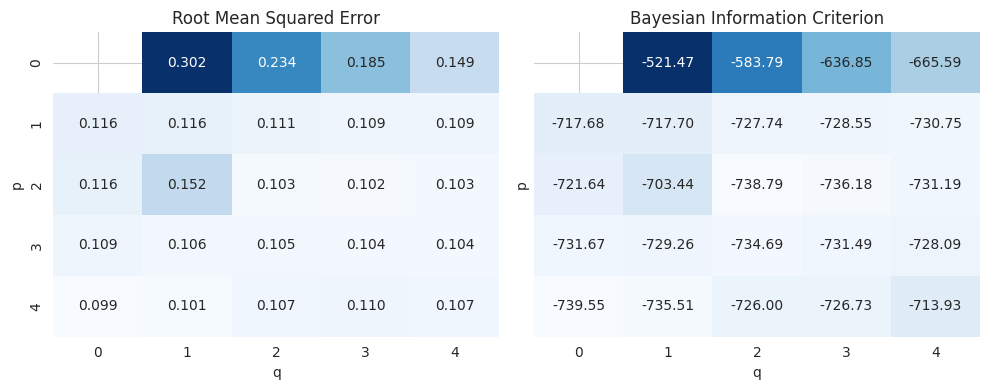

In [125]:
fig, axes = plt.subplots(ncols=2,
                         figsize=(10,4),
                         sharex=True,
                         sharey=True)

sns.heatmap(arima_results[arima_results.RMSE<.5].RMSE.unstack().mul(10),
            fmt='.3f',
            annot=True,
            cmap='Blues',
            ax=axes[0],
            cbar=False);

sns.heatmap(arima_results.BIC.unstack(),
            fmt='.2f',
            annot=True,
            cmap='Blues',
            ax=axes[1],
            cbar=False)

axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [127]:
arima_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
4  0    1.0
2  2    3.0
   3    3.0
4  1    3.0
2  4    6.5
dtype: float64

In [133]:
arima_results.rank().loc[:, ['RMSE', 'BIC']].mean(axis=1).nsmallest(5)

p  q
4  0    1.0
2  2    3.0
   3    3.0
4  1    3.0
2  4    6.5
dtype: float64

In [136]:
best_p, best_q = arima_results.rank().loc[:, ['RMSE', 'BIC']].mean(axis=1).idxmin()

In [137]:
best_arima_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p,0,best_q)).fit()
print(best_arima_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1104.301
Date:                Sat, 24 Jun 2023   AIC                          -2196.603
Time:                        22:11:33   BIC                          -2173.489
Sample:                    01-01-1989   HQIC                         -2187.401
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.010      1.879      0.060      -0.001       0.039
ar.L1          0.9329      0.044     21.023      0.000       0.846       1.020
ar.L2          0.3346      0.076      4.388      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


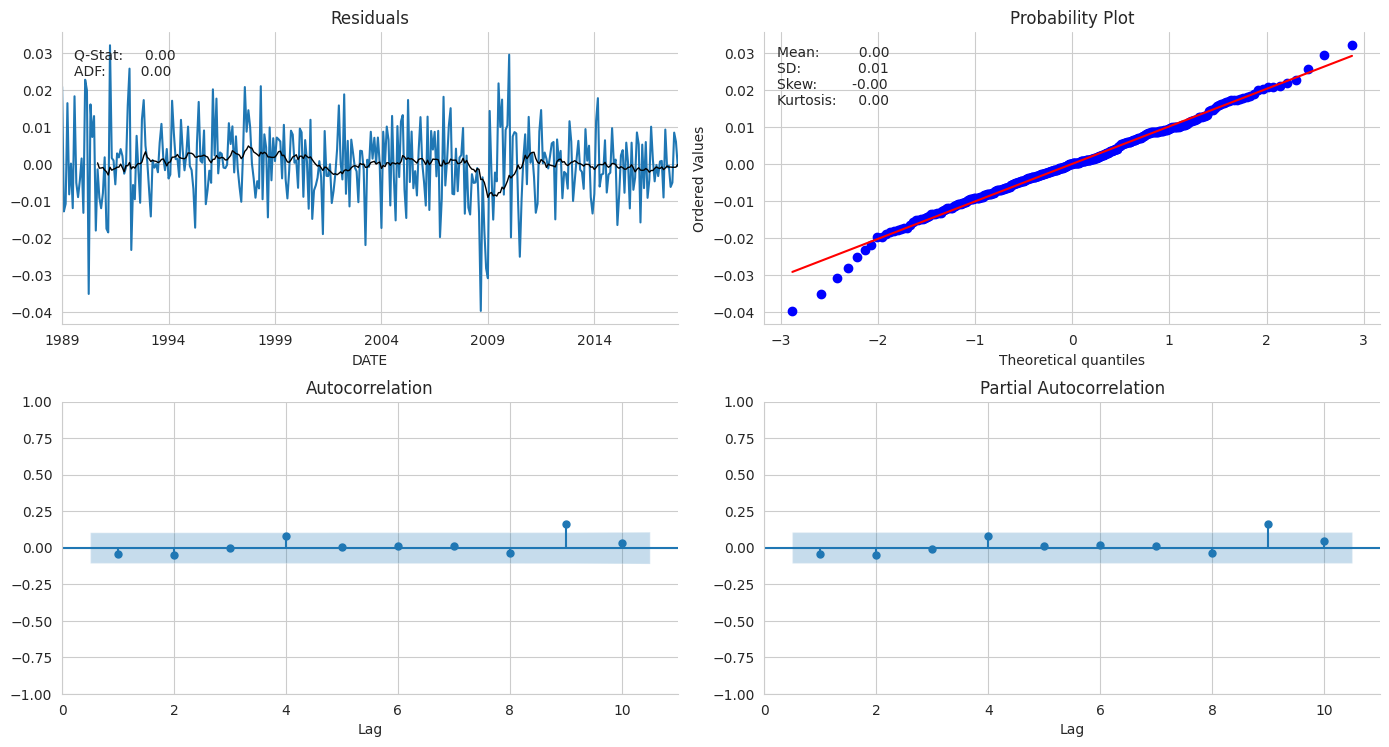

In [139]:
plot_correlogram(best_arima_model.resid)

In [140]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [141]:
print(sarimax_model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1126.638
Date:                              Sat, 24 Jun 2023   AIC                          -2239.277
Time:                                      22:15:03   BIC                          -2212.312
Sample:                                           0   HQIC                         -2228.541
                                              - 348                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0122      0.406      0.030      0.976      -0.784       0.809
ar.L2          0.98

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


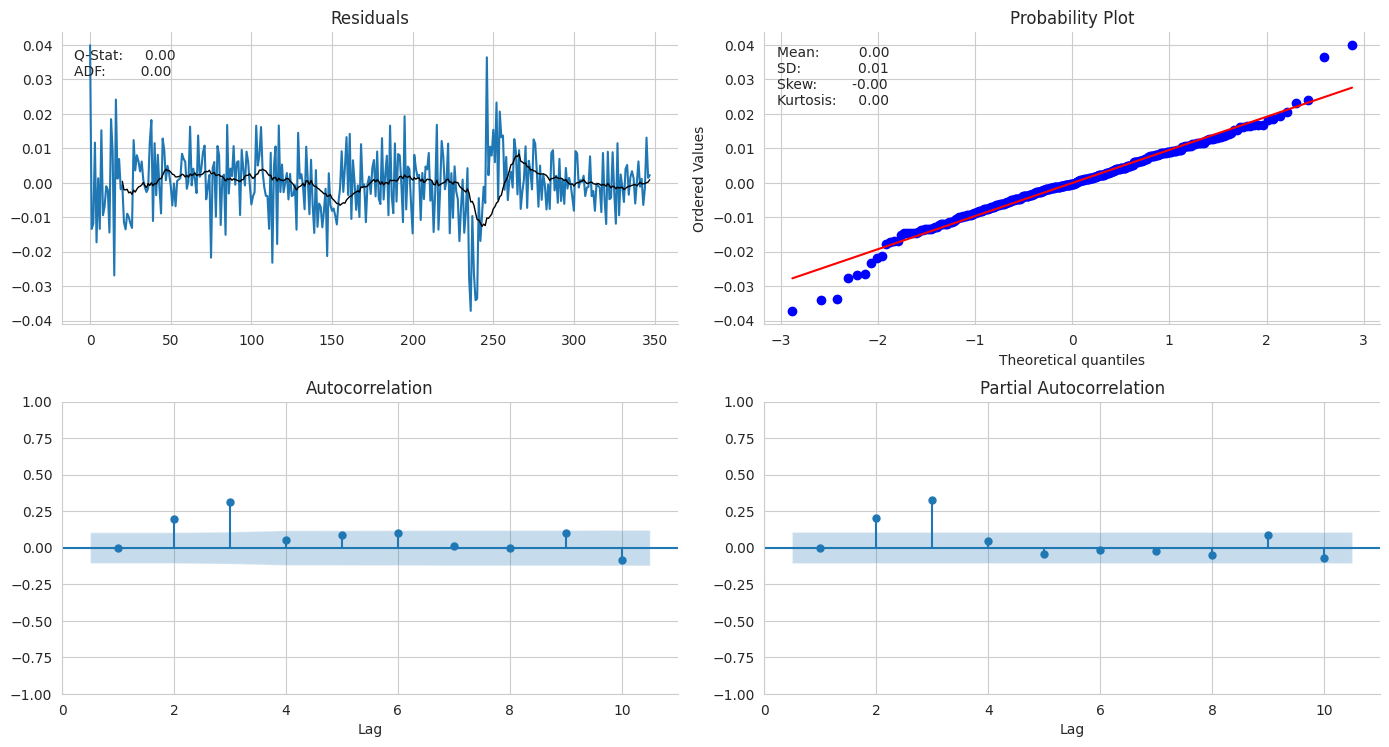

In [142]:
plot_correlogram(pd.Series(sarimax_model.resid))

In [17]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

81

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [150]:
len(industrial_production_log_diff)-train_size

228

In [ ]:
for i, T in enumerate(range(train_size, len(industrial_production_log_diff)-train_size)):
    print((T-train_size,T))

In [ ]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[-train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff)-train_size)):
        train_set = industrial_production_log_diff.iloc[T-train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                order=(p1, 0, q1),
                                seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                      preds.y_true.sub(preds.y_pred).pow(2).std(),
                                      np.mean(aic),
                                      np.std(aic),
                                      np.mean(bic),
                                      np.std(bic),
                                      convergence_error,
                                      stationarity_error]


 99%|█████████▉| 80/81 [4:07:28<04:30, 270.35s/it]

In [ ]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

In [ ]:
with pd.HDFStore('./data/arima.h5') as store:
    store.put('sarimax', sarimax_results)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-7a0ee6fa0297>", line 1, in <cell line: 1>
    with pd.HDFStore('./data/arima.h5') as store:
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/pytables.py", line 578, in __init__
    self.open(mode=mode, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/pytables.py", line 737, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tables/file.py", line 300, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tables/file.py", line 750, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 366, in tables.hdf5extension.File._g_new
  File "/usr/local/lib/python3.1

In [ ]:
sarimax_results.nsmallest(5, columns='RMSE')

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')


In [ ]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [ ]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

In [ ]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [ ]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [ ]:
print(best_model.summary())

In [ ]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')